# Question 4 and 5 Windy Gridworld Domain

In [101]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [102]:
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        self.action_space = {
            "up": np.array([-1, 0]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1]),
            "right": np.array([0, 1])
        }
        
        # Enable King's moves (Comment out the above action space to create a new one for King's moves)
        if enable_king_move:
            self.action_space["up-left"] = np.array([-1, -1])
            self.action_space["up-right"] = np.array([-1, 1])
            self.action_space["down-left"] = np.array([1, -1])
            self.action_space["down-right"] = np.array([1, 1])
            
        if enable_no_move:
            self.action_space["no-move"] = np.array([0, 0])
            
                
        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None

    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):
        # increment the time step
        self.t += 1
        # track the action
        self.act = act
        # determine the next state
        next_state = [self.state[0] + self.wind[self.state[1]] + self.action_space[act][0], 
                      self.state[1] + self.action_space[act][1]]
        # check if the next state is out of bounds
        next_state[0] = max(0, next_state[0])
        next_state[0] = min(6, next_state[0])
        next_state[1] = max(0, next_state[1])
        next_state[1] = min(9, next_state[1])
        # update the state
        self.state = next_state
        
        if self.state == self.goal_state:
            # calculate the reward
            reward = 0.0
            # check if the agent has reached the goal state
            terminated = True
        else:
            # calculate the reward
            reward = -1.0
            # check if the agent has reached the goal state
            terminated = False
            
        return self.state, reward, terminated

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)


In [103]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        rand = random.uniform(0, 1)
        if rand < self.epsilon:
            action = random.choice(list(self.env.action_space.keys()))
        else:
             # Exploitation: find the index of the state
            state_index = self.env.state_space.index(state)
            # Get the Q-values for all actions in this state
            q_values = self.Q[state_index, :]
            
            # Find the indices of actions with the maximum Q-value
            max_q_value = np.max(q_values)
            max_actions = np.flatnonzero(q_values == max_q_value)
            
            # Break ties randomly if there are multiple actions with the max Q-value
            if len(max_actions) > 1:
                chosen_action_idx = random.choice(max_actions)
            else:
                chosen_action_idx = np.argmax(q_values)
            
            # Select the corresponding action key
            action = list(self.env.action_space.keys())[chosen_action_idx]
        return action

    def update(self, s, a, r, s_prime, a_prime):
        self.Q[s, a] += self.alpha * (r + self.gamma * self.Q[s_prime, a_prime] - self.Q[s, a])
        return None

    def rollout(self):
        # reset the environment
        state, terminated = self.env.reset()
        # choose an action
        action = self.behavior_policy(state)
        # run the episode
        while not(terminated):
            # take the action
            next_state, reward, terminated = self.env.step(action)
            # choose the next action
            next_action = self.behavior_policy(next_state)
            # update the Q value
            self.update(self.env.state_space.index(state),
                        list(self.env.action_space.keys()).index(action),
                        reward,
                        self.env.state_space.index(next_state),
                        list(self.env.action_space.keys()).index(next_action))
            # update the state and action
            state = next_state
            action = next_action
        
        return None

    # Runs SARSA for the specified number of episodes returns an array of the total number of steps taken at each episode
    def run(self):
        steps = []
        for i in range(self.timeout):
            self.rollout()
            steps.append(self.env.t)
        return steps
        

In [104]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        rand = random.uniform(0, 1)
        if rand < self.epsilon:
            action = random.choice(list(self.env.action_space.keys()))
        else:
            # Exploitation: find the index of the state
            state_index = self.env.state_space.index(state)
            # Get the Q-values for all actions in this state
            q_values = self.Q[state_index, :]
            
            # Find the indices of actions with the maximum Q-value
            max_q_value = np.max(q_values)
            max_actions = np.flatnonzero(q_values == max_q_value)
            
            # Break ties randomly if there are multiple actions with the max Q-value
            if len(max_actions) > 1:
                chosen_action_idx = random.choice(max_actions)
            else:
                chosen_action_idx = np.argmax(q_values)
            
            # Select the corresponding action key
            action = list(self.env.action_space.keys())[chosen_action_idx]
        return action

    def update(self, s, a, r, s_prime, a_prime):
        # Expected SARSA update
        expected_values = []
        for action in self.env.action_space.keys():
            expected_values.append(self.Q[s_prime, list(self.env.action_space.keys()).index(action)])
        
        expected_value = 0
        max_actions = len(np.flatnonzero(expected_values == max(expected_values)))
        for val in expected_values:
            if val == max(expected_values):
                expected_value += val * ((1 - self.epsilon) / max_actions)
            else:
                expected_value += val * (self.epsilon / (len(expected_values) - max_actions))
            
        self.Q[s, a] += self.alpha * (r + self.gamma * expected_value - self.Q[s, a])
        return None
    
    def rollout(self):
        # reset the environment
        state, terminated = self.env.reset()
        # choose an action
        action = self.behavior_policy(state)
        # run the episode
        while not(terminated):
            # take the action
            next_state, reward, terminated = self.env.step(action)
            # choose the next action
            next_action = self.behavior_policy(next_state)
            # update the Q value
            self.update(self.env.state_space.index(state),
                        list(self.env.action_space.keys()).index(action),
                        reward,
                        self.env.state_space.index(next_state),
                        list(self.env.action_space.keys()).index(next_action))
            # update the state and action
            state = next_state
            action = next_action
        
        return None

    def run(self):
        steps = []
        for i in range(self.timeout):
            self.rollout()
            steps.append(self.env.t)
        return steps

In [105]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        rand = random.uniform(0, 1)
        if rand < self.epsilon:
            action = random.choice(list(self.env.action_space.keys()))
        else:
            # Exploitation: find the index of the state
            state_index = self.env.state_space.index(state)
            # Get the Q-values for all actions in this state
            q_values = self.Q[state_index, :]
            
            # Find the indices of actions with the maximum Q-value
            max_q_value = np.max(q_values)
            max_actions = np.flatnonzero(q_values == max_q_value)
            
            # Break ties randomly if there are multiple actions with the max Q-value
            if len(max_actions) > 1:
                chosen_action_idx = random.choice(max_actions)
            else:
                chosen_action_idx = np.argmax(q_values)
            
            # Select the corresponding action key
            action = list(self.env.action_space.keys())[chosen_action_idx]
        return action

    def update(self, s, a, r, s_prime):
        # Q-learning update
        self.Q[s, a] += self.alpha * (r + self.gamma * np.max(self.Q[s_prime, :]) - self.Q[s, a])
        return None

    def rollout(self):
        # reset the environment
        state, terminated = self.env.reset()
        # run the episode
        while not(terminated):
            # choose an action
            action = self.behavior_policy(state)
            # take the action
            next_state, reward, terminated = self.env.step(action)
            # update the Q value
            self.update(self.env.state_space.index(state),
                        list(self.env.action_space.keys()).index(action),
                        reward,
                        self.env.state_space.index(next_state))
            # update the state
            state = next_state
        
        return None

    def run(self):
        steps = []
        for i in range(self.timeout):
            self.rollout()
            steps.append(self.env.t)
        return steps

In [106]:
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

    Make sure the elements in the arr_list, legend_list, and color_list are associated with each other correctly.
    Do not forget to change the ylabel for different plots.
    """
    # Clear the current figure
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the mean and standard error while ignoring NaN values
        mean_arr = np.nanmean(arr, axis=0)
        arr_err = np.nanstd(arr, axis=0) / np.sqrt(np.sum(~np.isnan(arr), axis=0))
        
        # Plot the mean
        h, = ax.plot(mean_arr, range(len(mean_arr)), color=color, label=legend)
        
        # Plot the confidence band
        arr_err = 1.96 * arr_err  # 95% confidence interval
        ax.fill_betweenx(range(len(mean_arr)),
                        mean_arr - arr_err,
                        mean_arr + arr_err,
                        alpha=0.3, color=color)
        # Save the plot handle
        h_list.append(h)

    # Set the title (adjust as needed)
    ax.set_title("Windy Gridworld Results")
    ax.legend(handles=h_list)
    plt.show()

In [107]:
def run_on_policy_td_control(run_num, timeout, enable_king_move_actions = False, enable_no_move_actions = False):
     
    # create the environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions, enable_no_move=enable_no_move_actions)

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = .9

    
    # create the SARSA
    sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        # Calculate the cumulative sum of steps
        cumulative_steps = np.cumsum(episodes)

        # Get index where the cumulative steps equal 8000
        idx = np.where(cumulative_steps >= 8000)[0][0]

        # Slice the cumulative steps array to only include the first 8000 steps
        cumulative_steps = cumulative_steps[:idx]
        
        # append the results
        sarsa_results_list.append(cumulative_steps)
    
    max_rows = max([len(x) for x in sarsa_results_list])
    
    # Pad shorter arrays with NaN
    sarsa_results_list_padded = []
    for r in sarsa_results_list:
        # Convert array to float type if it's not already, to allow NaN padding
        r = np.array(r, dtype=np.float64)
        
        if len(r) < max_rows:
            r = np.pad(r, (0, max_rows - len(r)), constant_values=np.nan)
        sarsa_results_list_padded.append(r)

    # Stack the arrays into a 2D array
    stacked_array = np.vstack(sarsa_results_list_padded)
    
    # Create the Expected SARSA
    expected_sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        # Calculate the cumulative sum of steps
        cumulative_steps = np.cumsum(episodes)

        # Get index where the cumulative steps equal 8000
        idx = np.where(cumulative_steps >= 8000)[0][0]

        # Slice the cumulative steps array to only include the first 8000 steps
        cumulative_steps = cumulative_steps[:idx]
        
        # append the results
        expected_sarsa_results_list.append(cumulative_steps)
        
    max_rows = max([len(x) for x in expected_sarsa_results_list])
    
    # Pad shorter arrays with NaN
    expected_sarsa_results_list_padded = []
    for r in expected_sarsa_results_list:
        # Convert array to float type if it's not already, to allow NaN padding
        r = np.array(r, dtype=np.float64)
        
        if len(r) < max_rows:
            r = np.pad(r, (0, max_rows - len(r)), constant_values=np.nan)
        expected_sarsa_results_list_padded.append(r)
        
    # Stack the arrays into a 2D array
    expected_sarsa_array = np.vstack(expected_sarsa_results_list_padded)
    
    # Create the Q-learning
    q_learning_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        # Calculate the cumulative sum of steps
        cumulative_steps = np.cumsum(episodes)

        # Get index where the cumulative steps equal 8000
        idx = np.where(cumulative_steps >= 8000)[0][0]

        # Slice the cumulative steps array to only include the first 8000 steps
        cumulative_steps = cumulative_steps[:idx]
        
        # append the results
        q_learning_results_list.append(cumulative_steps)
    
    max_rows = max([len(x) for x in q_learning_results_list])
    
    # Pad shorter arrays with NaN
    q_learning_results_list_padded = []
    for r in q_learning_results_list:
        # Convert array to float type if it's not already, to allow NaN padding
        r = np.array(r, dtype=np.float64)
        
        if len(r) < max_rows:
            r = np.pad(r, (0, max_rows - len(r)), constant_values=np.nan)
        q_learning_results_list_padded.append(r)
        
    # Stack the arrays into a 2D array
    q_learning_array = np.vstack(q_learning_results_list_padded)
    
    # Plot the results
    
    plot_curves(
        [stacked_array, expected_sarsa_array, q_learning_array
         ],
        ['SARSA', 'Expected SARSA', 'Q-learning'
         ],
        ['r', 'b', 'g'
         ],
        "Episodes"
    )

<Figure size 640x480 with 0 Axes>

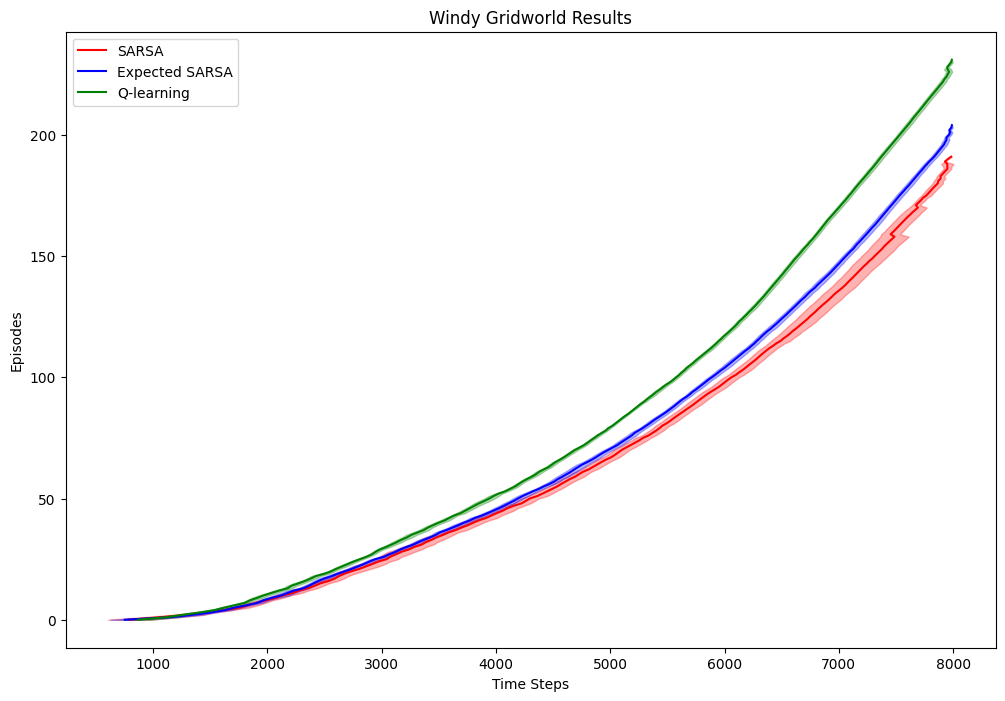

In [108]:
# set randomness
np.random.seed(1234)
random.seed(1234)

# trial number
trial_num = 10
# maximal time steps 
max_time_steps = 8000


# run SARSA and Q Learning
run_on_policy_td_control(trial_num, max_time_steps)

<Figure size 640x480 with 0 Axes>

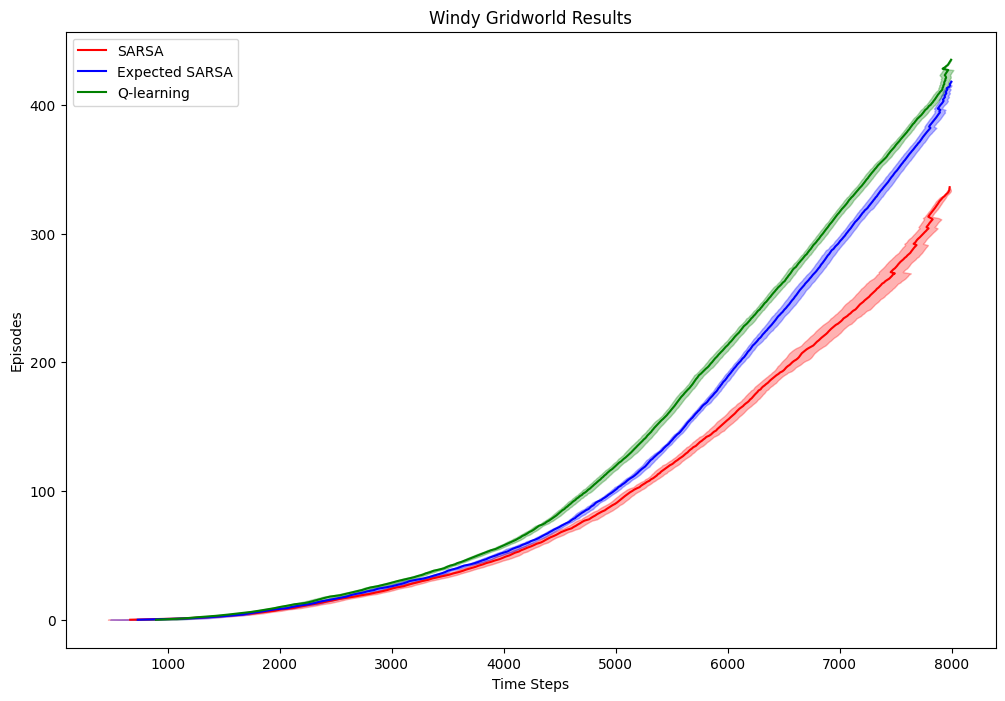

In [109]:
# run SARSA and Q Learning
run_on_policy_td_control(trial_num, max_time_steps, True)

<Figure size 640x480 with 0 Axes>

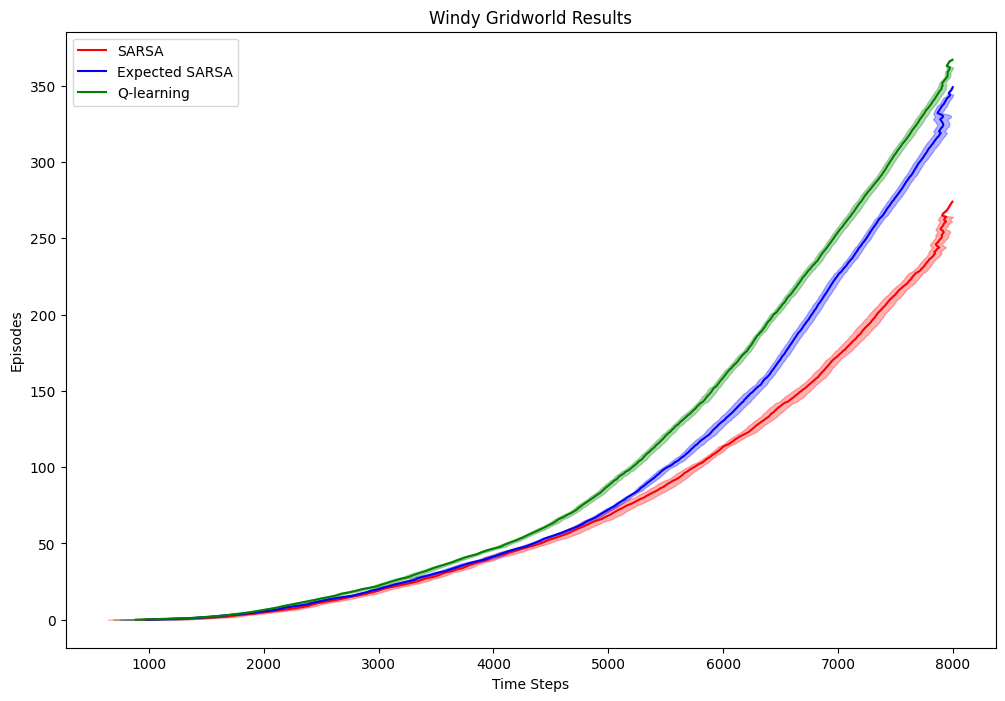

In [110]:
# run SARSA and Q Learning
run_on_policy_td_control(trial_num, max_time_steps, True, True)

# Question 5 [5180 ONLY]
- Please refer to starter code from question 4 to help you get started. You will create your own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain. 
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to      estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. In
this question, S is the initial state marked as S in the Example 6.5.
- To do so, you need to collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.
- Note that in practice you should pre-collect both the training and evaluation episodes for efficiency and to
ensure consistency while comparing between different methods.

In [111]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld():
    enable_king_move_actions = False
    enable_no_move_actions = False
    
    # create environments
    env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                         enable_no_move=enable_no_move_actions)
    env.reset()

In [112]:
if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # run Monte Carlo and TD(0) for Question 6. Modify as necessary
    run_on_policy_mc_td_epsilon_greedy_windy_gridworld()